# Bayesian Deconvolution

We'll revisit the deblurring, denoising, and inpainting problems we saw in the last chapter. And we'll see how Bayesian methods will allow us to improve performance by asserting information about the structure of the orginial image. We'll first grab an image from LFW.

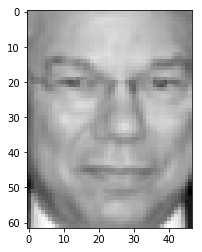

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=100)
this_face = lfw_people.images[405]
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

height = this_face.shape[0]
width = this_face.shape[1]
size = height*width

Next, we'll look at the blur operation again. We defined its impulse response in the 'time' domain. Let's also look at its frequency domain characteristics.

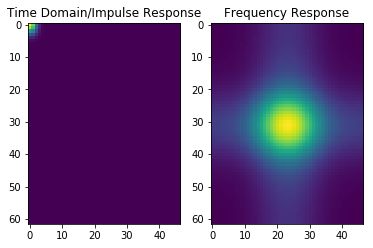

In [2]:
#First, we need to build the impulse response of the blur.

scale = 5
t = np.linspace(0, 10, height)
s = np.linspace(0, 10, width)
vert = np.exp(-scale*t**2)
#vert /= np.sum(vert) # normalize the impulse response
horiz = np.exp(-scale*s**2)
#horiz /= np.sum(horiz)
kernel =  np.outer(vert, horiz) #make a 2D impulse response
kernel_FR = np.fft.fftshift(np.fft.fft2(kernel))
h = kernel.flatten()

#Now we need to make a matrix operator out of it.
H = sp.linalg.toeplitz(h)

sub = plt.subplot(1,2,1)
plt.imshow(kernel)
plt.title('Time Domain/Impulse Response')

sub = plt.subplot(1,2,2)
plt.imshow(np.absolute(kernel_FR))
plt.title('Frequency Response')
plt.show()

A well-known fact in signal processing is that the Fourier transform of a Gaussian is itself Gaussian. The frequency response of the Gaussian blur is also Gaussian -- it operates like a low-pass filter whose width is inversely proportional of the width of the blur in the time domain.

As a result, the ML filter significantly amplifies noise at higher frequencies. Can we mitigate this issue by imposing a prior?

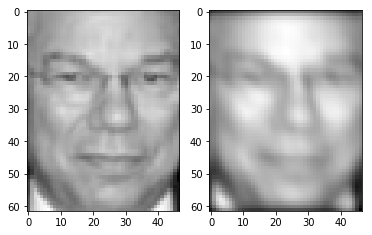

In [5]:
sigma_2 = 0.1 #noise variance
x = this_face.flatten() #treat the image as a vector
y = H@x + np.sqrt(sigma_2)*np.random.randn(size)

y_image = np.reshape(y,(height,width))

sub = plt.subplot(1,2,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,2,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

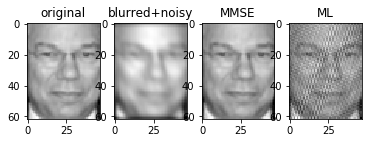

0.00015663666166
0.0190320229175


In [6]:
sigma_2_x = 1

x_hat = sigma_2_x*H.T@np.linalg.inv(sigma_2_x*H@H.T + sigma_2*np.eye(size))@y
x_hat_image = np.reshape(x_hat,(height, width))

x_hat_ML = np.linalg.pinv(H)@y
x_hat_ML_image = np.reshape(x_hat_ML,(height, width))

sub = plt.subplot(1,4,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")
plt.title('original')

sub = plt.subplot(1,4,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")
plt.title('blurred+noisy')

sub = plt.subplot(1,4,3)
plt.imshow(x_hat_image,cmap=plt.cm.gray,interpolation="nearest")
plt.title('MMSE')

sub = plt.subplot(1,4,4)
plt.imshow(x_hat_ML_image,cmap=plt.cm.gray,interpolation="nearest")
plt.title('ML')
plt.show()

NMSE_MMSE = (np.linalg.norm(x - x_hat)/np.linalg.norm(x))**2
NMSE_ML = (np.linalg.norm(x - x_hat_ML)/np.linalg.norm(x))**2
print(NMSE_MMSE)
print(NMSE_ML)

As expected (and as we saw last time), the ML estimator amplifies high frequency noise, which results in the artifacts present in the deblurred image. However, the MMSE estimator accounts for the structure of the filter, and does not show these artifacts. The more noise we add to the image, the more severe these effects.

Now, let's return to inpainting, where the ML estimator was of no use. How well will a simple prior do?

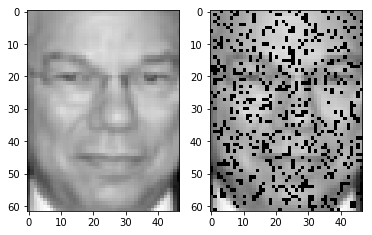

In [6]:
loss_ratio = 0.2
h = np.random.binomial(1,1-loss_ratio,size)
H = np.diag(h)

y = H@x + np.sqrt(sigma_2)*np.random.randn(size)
y_image = np.reshape(y,(height,width))

sub = plt.subplot(1,2,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,2,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

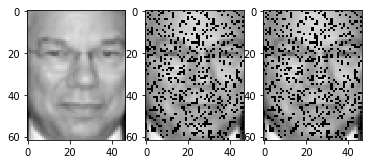

In [7]:
sigma_2_x = 1

x_hat = sigma_2_x*H.T@np.linalg.inv(sigma_2_x*H@H.T + sigma_2*np.eye(size))@y
x_hat_image = np.reshape(x_hat,(height, width))

sub = plt.subplot(1,3,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,3)
plt.imshow(x_hat_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

This still isn't doing much. This prior is has a diagonal covariance--it asserts an average power on the signal, but nothing of correlations among pixel values. As a result, it can't tell us how to estimate the missing pixel values. Instead, we need to give a more complex prior.

We'll choose a "low-pass prior", which asserts the the signal energy is concentrated at low frequencies. We'll do this by supposing that the correlations between pixels are exponential in their distance.

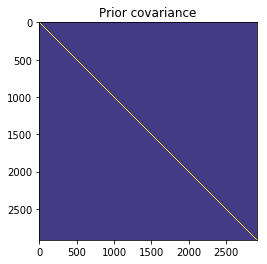

In [7]:
k = 1000

f = np.zeros(size)
f[0:k+1] = 1
f[-k:] = 1

U = sp.linalg.dft(size,scale='sqrtn')

Sigma_x = np.real(U.conj().T@np.diag(f)@U)

#Sigma_x = np.zeros((size,size))
#for i in range(0,size):
#    for j in range(0,size):
#        Sigma_x[i,j] = np.exp(-scale*np.absolute(i-j))

plt.imshow(Sigma_x)
plt.title('Prior covariance')
plt.show()

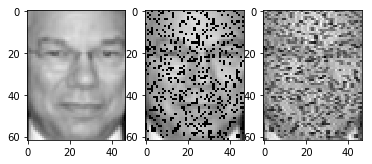

In [16]:
x_hat = Sigma_x@H.T@np.linalg.inv(H@Sigma_x*H.T + sigma_2*np.eye(size))@y
x_hat_image = np.reshape(x_hat,(height, width))

sub = plt.subplot(1,3,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,3)
plt.imshow(x_hat_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()

This really isn't satisfactory. Essentially all we've done is apply a low-pass filter to the inpainted image, which blurs out the missing pixels somewhat, but also blurs out the *correct* part of the image. Perhaps a data-driven prior will work better. Let's try using the sample mean and covariance of the whole dataset.

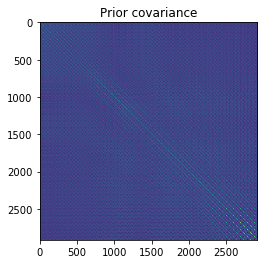

In [17]:
num_samples = len(lfw_people.images)
images = np.reshape(lfw_people.images,(num_samples,size))

mu_x = np.mean(images,0)
centered_images = images - mu_x
Sigma_x = 1/num_samples*(centered_images.T@centered_images)

plt.imshow(Sigma_x)
plt.title('Prior covariance')
plt.show()

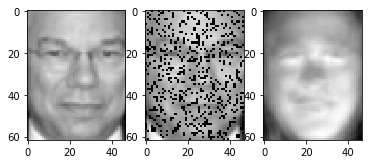

In [18]:
x_hat = mu_x + Sigma_x@H.T@np.linalg.inv(H@Sigma_x*H.T + sigma_2*np.eye(size))@(y-H@mu_x)
x_hat_image = np.reshape(x_hat,(height, width))

sub = plt.subplot(1,3,1)
plt.imshow(this_face,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,2)
plt.imshow(y_image,cmap=plt.cm.gray,interpolation="nearest")

sub = plt.subplot(1,3,3)
plt.imshow(x_hat_image,cmap=plt.cm.gray,interpolation="nearest")
plt.show()